# Distance benchmarks from CLASS

This note generates the benchmarks for comoving radial distances and distance moduli using CLASS. It uses the benchmark models defined in the CCL paper (CCL1-11, not including CCL6), as well as some additional models with unconventional neutrino configurations.
The benchmarks were created with the public version of CLASS (v2.6.3).

In [1]:
import collections

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate

import classy

The set of common cosmological parameters. The standard integration stepsize is insufficient at very low redshift (z=0.01) when agreement with CCL at the 1e-5 level is required. We thus set `back_integration_stepsize` to something lower.

In [2]:
class_params = {"output"    : "",
                "T_cmb"     : 2.725,
                "h"         : 0.7,
                "Omega_cdm" : 0.25,
                "Omega_b"   : 0.05,
                "A_s"       : 2e-9,
                "n_s"       : 1.0,
                "back_integration_stepsize" : 1.0e-3, # Required for agreement at <1e-5 with CCL.
               }

Define a set of models with different curvature and number of neutrinos (both massless and massive).

In [3]:
models = [("flat_nonu",         {"Omega_k"  : 0.0,
                                 "N_ur"     : 3.0}),
          ("pos_curv_nonu"    , {"Omega_k"  : 0.01,
                                 "N_ur"     : 3.0}),
          ("neg_curv_nonu"    , {"Omega_k"  : -0.01,
                                 "N_ur"     : 3.0}),
          ("flat_massnu1"     , {"Omega_k"  : 0.0,
                                 "N_ur"     : 2.0,         # 1 massive neutrino
                                 "N_ncdm"   : 1,           # 1 species
                                 "m_ncdm"   : 0.1}),        # Mass
          ("flat_massnu2"     , {"Omega_k"  : 0.0,
                                 "N_ur"     : 0.0,         # 3 massive neutrinos
                                 "N_ncdm"   : 2,           # 2 species
                                 "m_ncdm"   : "0.03, 0.1", # Masses
                                 "deg_ncdm" : "2, 1"}),     # Degeneracy
          ("flat_massnu3"     , {"Omega_k"  : 0.0,
                                 "N_ur"     : 0.0,               # 3 massive neutrinos
                                 "N_ncdm"   : 3,                 # 3 species
                                 "m_ncdm"   : "0.03, 0.05, 0.1", # Masses
                                 "deg_ncdm" : "1, 1, 1"}),        # Degeneracy
          ("flat_manynu1"     , {"Omega_k"  : 0.0,
                                 "N_ur"     : 6.0}),         # 6 massless neutrinos
          ("neg_curv_massnu1" , {"Omega_k"  : -0.01,
                                 "N_ur"     : 4.0,         # 4 massless neutrinos
                                 "N_ncdm"   : 2,           # 2 species of massive neutrinos
                                 "m_ncdm"   : "0.03, 0.1", # Masses
                                 "deg_ncdm" : "1, 1"}),     # Degeneracy
          ("pos_curv_manynu1" , {"Omega_k"  : 0.01,
                                 "N_ur"     : 3.0,               # 3 massless neutrinos
                                 "N_ncdm"   : 3,                 # 2 species of massive neutrinos
                                 "m_ncdm"   : "0.03, 0.05, 0.1", # Masses
                                 "deg_ncdm" : "1, 1, 1"}),        # Degeneracy
          
          # For consistency with existing CCL tests
          ("CCL1" ,             {"Omega_k"      : 0.0,
                                 "n_s"          : 0.96,
                                 "N_ur"         : 3.046,  
                                 "N_ncdm"       : 0}),
          ("CCL2" ,             {"Omega_k"      : 0.0,
                                 "Omega_Lambda" : 0.0,
                                 "w0_fld"       : -0.9,
                                 "wa_fld"       : 0.0,
                                 "N_ur"         : 3.046,  
                                 "N_ncdm"       : 0}),
          ("CCL3" ,             {"Omega_k"      : 0.0,
                                 "Omega_Lambda" : 0.0,
                                 "w0_fld"       : -0.9,
                                 "wa_fld"       : 0.1,
                                 "N_ur"         : 3.046,  
                                 "N_ncdm"       : 0}),
          ("CCL4" ,             {"Omega_k"      : 0.05,
                                 "Omega_Lambda" : 0.0,
                                 "w0_fld"       : -0.9,
                                 "wa_fld"       : 0.1,
                                 "N_ur"         : 3.046,  
                                 "N_ncdm"       : 0}),
          ("CCL5" ,             {"Omega_k"      : -0.05,
                                 "Omega_Lambda" : 0.0,
                                 "w0_fld"       : -0.9,
                                 "wa_fld"       : 0.1,
                                 "N_ur"         : 3.046,  
                                 "N_ncdm"       : 0}),
          
          ("CCL7" ,             {"Omega_k"      : 0.0,
                                 "N_ur"         : 2.0,  
                                 "N_ncdm"       : 1,                 
                                 "m_ncdm"       : 0.04}), 
          ("CCL8" ,             {"Omega_k"      : 0.0,
                                 "Omega_Lambda" : 0.0,
                                 "w0_fld"       : -0.9,
                                 "wa_fld"       : 0.0,
                                 "N_ur"         : 1.0,  
                                 "N_ncdm"       : 2,                 
                                 "m_ncdm"       : "0.05, 0.01"}),
          ("CCL9" ,             {"Omega_k"      : 0.0,
                                 "Omega_Lambda" : 0.0,
                                 "w0_fld"       : -0.9,
                                 "wa_fld"       : 0.1,
                                 "N_ur"         : 0.0,  
                                 "N_ncdm"       : 3,                 
                                 "m_ncdm"       : "0.03, 0.02, 0.04"}),
          ("CCL10" ,            {"Omega_k"      : 0.05,
                                 "Omega_Lambda" : 0.0,
                                 "w0_fld"       : -0.9,
                                 "wa_fld"       : 0.1,
                                 "N_ur"         : 2.0,  
                                 "N_ncdm"       : 1,                 
                                 "m_ncdm"       : 0.05}),
          ("CCL11" ,            {"Omega_k"      : -0.05,
                                 "Omega_Lambda" : 0.0,
                                 "w0_fld"       : -0.9,
                                 "wa_fld"       : 0.1,
                                 "N_ur"         : 1.0,  
                                 "N_ncdm"       : 2,                 
                                 "m_ncdm"       : "0.03, 0.02"}), 
        ]

Run CLASS and get the comoving distances.

In [4]:
z = np.logspace(-1, 3, 50, endpoint=True)

d_ang = collections.OrderedDict()
d_ang_direct = collections.OrderedDict()
d_co = collections.OrderedDict()

z_class = collections.OrderedDict()

for (model_name, model) in models:
    print("Computing {}".format(model_name))

    cosmo = classy.Class()
    cosmo.set({**class_params, **model})
    cosmo.compute()

    z_class[model_name] = cosmo.get_background()["z"][:]
    d_co[model_name] = cosmo.get_background()["comov. dist."][:]
    d_ang[model_name] = cosmo.get_background()["ang.diam.dist."][:]

    d_ang_direct[model_name] = np.array([cosmo.angular_distance(x) for x in z])
    cosmo.struct_cleanup()

Computing flat_nonu
Computing pos_curv_nonu
Computing neg_curv_nonu
Computing flat_massnu1
Computing flat_massnu2
Computing flat_massnu3
Computing flat_manynu1
Computing neg_curv_massnu1
Computing pos_curv_manynu1
Computing CCL1
Computing CCL2
Computing CCL3
Computing CCL4
Computing CCL5
Computing CCL7
Computing CCL8
Computing CCL9
Computing CCL10
Computing CCL11


Check the interpolation error in z.

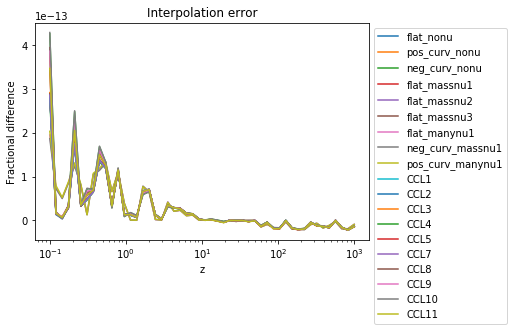

In [5]:
for model_name, da in d_ang.items():
    intp = scipy.interpolate.InterpolatedUnivariateSpline(z_class[model_name][::-1], da[::-1])
    plt.plot(z, intp(z)/d_ang_direct[model_name] - 1, label=model_name)

plt.xscale("log")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("z")
plt.ylabel("Fractional difference")
_ =plt.title("Interpolation error")

Plot the angular diameter distance for the different models defined above.

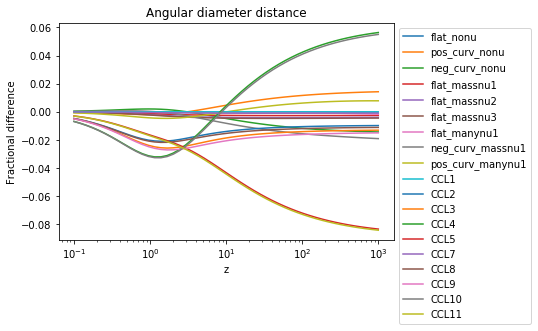

In [6]:
fid_model = "flat_nonu"
for model_name, da in d_ang.items():
    intp1 = scipy.interpolate.InterpolatedUnivariateSpline(z_class[fid_model][::-1], d_ang[fid_model][::-1])
    intp2 = scipy.interpolate.InterpolatedUnivariateSpline(z_class[model_name][::-1], da[::-1])
    plt.plot(z, intp2(z)/intp1(z)-1, label=model_name)

plt.xscale("log")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("z")
plt.ylabel("Fractional difference")
_ = plt.title("Angular diameter distance")

# Create benchmark files

Create the benchmark files for the whole redshift range (`allz`)

In [7]:
chi_benchmark_file = "../chi_class_allz.txt"
dm_benchmark_file = "../dm_class_allz.txt"

z = np.logspace(-2, 3, 10, endpoint=True)

chi = np.zeros((11, len(z)))
dm = np.zeros((11, len(z)))

chi[0] = z
dm[0] = z

CCL_paper_models = ["CCL1", "CCL2", "CCL3", "CCL4", "CCL5",
                    "CCL7", "CCL8", "CCL9", "CCL10", "CCL11"]

for i, model in enumerate(CCL_paper_models):
    chi_intp = scipy.interpolate.InterpolatedUnivariateSpline(z_class[model][::-1], d_co[model][::-1])
    chi[i+1] = chi_intp(z)
    
    d_ang_intp = scipy.interpolate.InterpolatedUnivariateSpline(z_class[model][::-1], d_ang[model][::-1])
    dL = d_ang_intp(z) * (1+z)**2
    dm[i+1] = 5*np.log10(dL*1e6) - 5
    
np.savetxt(chi_benchmark_file, chi.T, header="z " + "   ".join(CCL_paper_models))
np.savetxt(dm_benchmark_file, dm.T, header="z " + "   ".join(CCL_paper_models))

Create benchmarks also using the split between low and high redshift (`lowz` and `hiz`).

In [8]:
z_low = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
z_high = np.array([10.0, 20.0, 50.0, 100.0, 200.0, 500.0, 1000.0])

chi_low_z_benchmark = np.zeros((len(z_low), 11))
chi_low_z_benchmark[:,0] = z_low
chi_high_z_benchmark = np.zeros((len(z_high), 11))
chi_high_z_benchmark[:,0] = z_high

chi_low_z_benchmark_file= "../chi_class_lowz.txt"
chi_high_z_benchmark_file= "../chi_class_hiz.txt"

CCL_paper_models = ["CCL1", "CCL2", "CCL3", "CCL4", "CCL5",
                    "CCL7", "CCL8", "CCL9", "CCL10", "CCL11"]

for i, model in enumerate(CCL_paper_models):
    intp = scipy.interpolate.InterpolatedUnivariateSpline(z_class[model][::-1], d_co[model][::-1])
    chi_low_z_benchmark[:,i+1] = intp(z_low)
    chi_high_z_benchmark[:,i+1] = intp(z_high)

np.savetxt(chi_low_z_benchmark_file, chi_low_z_benchmark, header="z " + "   ".join(CCL_paper_models))
np.savetxt(chi_high_z_benchmark_file, chi_high_z_benchmark, header="z " + "   ".join(CCL_paper_models))


Create the benchmark files for the additional neutrino models.

In [9]:
chi_benchmark_file= "../chi_class_extra_mnu.txt"
dm_benchmark_file= "../dm_class_extra_mnu.txt"
z_min = 0.01
z_max = 1050.0
n_z = 10
z = np.logspace(np.log10(z_min), np.log10(z_max), n_z, endpoint=True)

chi = np.zeros((10, len(z)))
dm = np.zeros((10, len(z)))

chi[0] = z
dm[0] = z

extra_mnu_models = ["flat_nonu", "pos_curv_nonu", "neg_curv_nonu", 
                    "flat_massnu1", "flat_massnu2", "flat_massnu3", 
                    "flat_manynu1", "neg_curv_massnu1", "pos_curv_manynu1"]

for i, model in enumerate(extra_mnu_models):
    chi_intp = scipy.interpolate.InterpolatedUnivariateSpline(z_class[model][::-1], d_co[model][::-1])
    chi[i+1] = chi_intp(z)
    
    d_ang_intp = scipy.interpolate.InterpolatedUnivariateSpline(z_class[model][::-1], d_ang[model][::-1])
    dL = d_ang_intp(z) * (1+z)**2
    dm[i+1] = 5*np.log10(dL*1e6) - 5
    
np.savetxt(chi_benchmark_file, chi.T, header="z " + "   ".join(extra_mnu_models))
np.savetxt(dm_benchmark_file, dm.T, header="z " + "   ".join(extra_mnu_models))